In [1]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import concatenate
import numpy as np
import argparse
import locale
import os
import pickle
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Input, Dense, concatenate
from keras.models import Model
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torch
import torch.optim as optim
import torchvision.transforms as T
from sklearn.metrics import accuracy_score,roc_auc_score,auc,confusion_matrix,roc_curve
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn import preprocessing
import Loader
import heapq

In [2]:
m = loadmat("ADNI.mat") 

In [3]:
min_max_scaler = preprocessing.MinMaxScaler()

In [4]:
AD=np.zeros((m['AD'].shape[0],2,93))
for i in range(m['AD'].shape[0]):
    AD_i= m['AD'][i][:].reshape(2,93)
    #AD[i][0:2][:]=min_max_scaler.fit_transform(AD_i)
    AD[i][0:2][:]=AD_i
NC=np.zeros((m['NC'].shape[0],2,93))
for i in range(m['NC'].shape[0]):
    NC_i=  m['NC'][i][:].reshape(2,93)
    #NC[i][0:2][:]=min_max_scaler.fit_transform(NC_i)
    NC[i][0:2][:]=NC_i
MCIn=np.zeros((m['MCIn'].shape[0],2,93))
for i in range(m['MCIn'].shape[0]):
    MCIn_i=  m['MCIn'][i][:].reshape(2,93)
    MCIn[i][0:2][:]=MCIn_i
MCIp=np.zeros((m['MCIp'].shape[0],2,93))
for i in range(m['MCIp'].shape[0]):
    MCIp_i=  m['MCIp'][i][:].reshape(2,93)
    MCIp[i][0:2][:]=MCIp_i

In [5]:
label_AD = [0]*m['AD'].shape[0]
label_NC = [1]*m['NC'].shape[0]
label_MCIn = [2]*m['MCIn'].shape[0]
label_MCIp= [3]*m['MCIp'].shape[0]
AD = AD.tolist()
NC = NC.tolist()
MCIn = MCIn.tolist()
MCIp = MCIp.tolist()
df = AD + NC
label = label_AD + label_NC
df = np.array(df)
print(df.shape)
label = np.array(label)
AD = np.array(AD)
dataset=AD
print(AD.shape)
NC = np.array(NC)
print(NC.shape)
label_AD=np.array(label_AD)
label_NC=np.array(label_NC)

(103, 2, 93)
(51, 2, 93)
(52, 2, 93)


In [6]:
def cor_cal(data):
    data = np.corrcoef(data)
    data = np.tril(data)
    len = data.shape[0]
    new_data = []
    for i in range(len):
        for j in range(i):
            new_data.append(data[i, j])
    data = np.asarray(new_data)
    data = data.astype(np.float32)
    return data

In [7]:
def array2dataset(x_train,x_test,y_train,y_test,batch_size):        
    x_train=torch.from_numpy(x_train)
    y_train=torch.from_numpy(y_train)
    x_test=torch.from_numpy(x_test)
    y_test=torch.from_numpy(y_test)
    x_train=x_train.float()
    print(x_train.shape)
    x_test=x_test.float()
    print(x_test.shape)
    y_train=y_train.long()
    y_test=y_test.long()
    train_dataset=TensorDataset(x_train,y_train)
    test_dataset=TensorDataset(x_test,y_test)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size, shuffle=True)
    return train_loader,test_loader

In [8]:
x_train,x_test,y_train,y_test = train_test_split(df,label,test_size =0.1)  
train_dataset,test_dataset=array2dataset(x_train,x_test,y_train,y_test,64)

torch.Size([92, 2, 93])
torch.Size([11, 2, 93])


In [9]:
def auc_sens_spe_cal(real,pred,draw='false'):
    fpr,tpr,threshold = roc_curve(real, pred) 
    roc_auc = auc(fpr,tpr)
    if(draw=='true'):
        plt.figure()
        lw = 2
        plt.figure(figsize=(5,5))
        plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='test ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
    if(len(set(real))!=1):
        roc=roc_auc_score(real, pred)
        sensitivity=confusion_matrix(real, pred)[0][0]/(confusion_matrix(real, pred)[0][0]+confusion_matrix(real, pred)[0][1])
        specificity=confusion_matrix(real, pred)[1][1]/(confusion_matrix(real, pred)[1][1]+confusion_matrix(real, pred)[1][0])
    else:
        roc=0
        sensitivity=0
        specificity=0
    return roc,sensitivity,specificity

In [15]:
class NET1(nn.Module):
    def __init__(self):
        super(NET1, self).__init__()

        self.net_in1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(93*2, 512),
            #nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.LeakyReLU()
        )
        self.res11 = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU()
        )
        self.res12 = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU()
        )
        self.res13 = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU()
        )
        self.net_out1 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU()
        )
        
        self.linear1 = nn.Linear(256,64)
        self.relu=nn.LeakyReLU()
        self.batchNorm1d1 = nn.BatchNorm1d(64)
        self.linear2 = nn.Linear(64,2)
        self.batchNorm1d2 = nn.BatchNorm1d(16)
        self.linear3 = nn.Linear(16,2)
        self.fc = nn.Linear(1024,512)
    def forward(self, x):
        x = x.reshape((x.shape[0],-1))

        x11 = self.net_in1(x)
        x12 = self.res11(x11)
        x13 = self.res12(x11 + x12)
        x14 = self.res13(x12 + x13)
        x15 = self.net_out1(x13 + x14)

        y = self.linear1(x15)
        y = self.relu(y)
        y = self.batchNorm1d1(y)
        y = self.linear2(y)
        #print(out.shape)
        return y

In [16]:
transform_normal = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
])

In [17]:
loss=nn.CrossEntropyLoss()

In [18]:
def train_n_test(train_iter,test_iter,epochs=500,learning_rate = 0.01):
    net1=NET1().cuda()
    optimizer= optim.Adam(net1.parameters(), lr=learning_rate,weight_decay=0.1)
    test_accuracies = []
    train_accuracies=[]
    all_Auc_score=[]
    all_sensitivity=[]
    all_specificity=[]
    best_accuracy=0
    best_train_accuracy=0
    best_epoch=1
    best_real=[]
    best_pred=[]
    for epoch in range(epochs):
        train_l_sum, train_acc_sum, n1 = 0.0, 0.0, 0
        if epoch%100==0:
            for p in optimizer.param_groups:
                p['lr']*=0.8
        for X, y in train_iter:
            X=X.cuda()
            y=y.cuda()
            y_hat= net1(X)
            l = loss(y_hat, y).sum()
            l=l.cuda()
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n1 += y.shape[0]
        test_acc_sum, n2 =0.0, 0
        Auc_score,sensitivity,specificity=0,0,0
        real=[]
        pred=[]
        for X,y in test_iter:
            X=X.cuda()
            y=y.cuda()
            y_hat= net1(X)
            test_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n2 += y.shape[0]
            batch_pred=y_hat.argmax(dim=1)
            for i in range(y.shape[0]):
                real.append(y[i].item())
                pred.append(batch_pred[i].item())
        Auc_score,sensitivity,specificity=auc_sens_spe_cal(real,pred)
        train_accuracies.append(train_acc_sum / n1)
        test_accuracies.append(test_acc_sum/n2)
        if(test_acc_sum/n2>=best_accuracy):
            best_train_accuracy=train_acc_sum / n1
            best_accuracy=test_acc_sum/n2
            best_epoch=epoch + 1
            best_real=real
            best_pred=pred
        print('\r epoch %d, 训练集正确率 %.3f, 验证集正确率 %.3f, Auc score %.3f, sensitivity %.3f, specificity %.3f '
              % (epoch + 1, train_acc_sum / n1, test_acc_sum/n2,Auc_score,sensitivity,specificity),end='')
    record_accuracy = sum(heapq.nlargest(5,test_accuracies))/5
    best_Auc_score,best_sensitivity,best_specificity=0,0,0
    best_Auc_score,best_sensitivity,best_specificity=auc_sens_spe_cal(best_real,best_pred,draw='true')
    print('\n 最好情况下：epoch %d, 训练集正确率 %.3f, 验证集正确率 %.3f, Auc score %.3f, sensitivity %.3f, specificity %.3f '
            % (best_epoch,best_train_accuracy, best_accuracy,best_Auc_score,best_sensitivity,best_specificity))
    plt.figure()
    lw = 2
    plt.figure(figsize=(5,5))
    plt.plot(train_accuracies, color='darkorange',
            lw=lw, label='train curve')
    plt.plot(test_accuracies, color='lightgreen',
            lw=lw, label='test curve')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('Accuracy Curve')
    plt.ylim([0.0, 1])
    plt.legend(loc="lower right")
    plt.show()
    return best_train_accuracy,record_accuracy,best_Auc_score,best_sensitivity,best_specificity

 epoch 500, 训练集正确率 0.989, 验证集正确率 0.909, Auc score 0.929, sensitivity 0.857, specificity 1.000 

<Figure size 432x288 with 0 Axes>

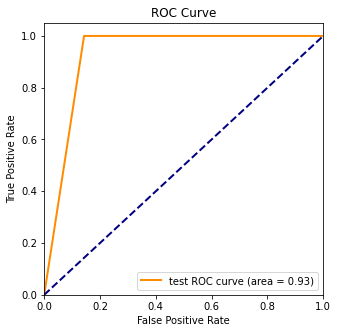


 最好情况下：epoch 500, 训练集正确率 0.989, 验证集正确率 0.909, Auc score 0.929, sensitivity 0.857, specificity 1.000 


<Figure size 432x288 with 0 Axes>

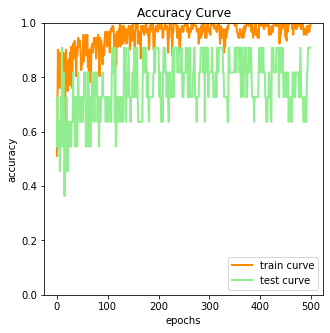

(0.9891304347826086,
 0.909090909090909,
 0.9285714285714286,
 0.8571428571428571,
 1.0)

In [19]:
train_n_test(train_dataset,test_dataset,epochs=500,learning_rate = 0.05)

In [20]:
def kfold_train_test(n):
    from sklearn.model_selection import KFold
    accuracy = list()   
    train_accuracy = [] 
    roc_all=[]
    sensitivity_all=[]
    specificity_all=[]
    k=1    #10折交叉验证重复k次
    for i in range(k):
        kfold = KFold(n_splits=n,shuffle=True)
        count=1
        for train_index, test_index in kfold.split(df, label):
            # train_index 就是分类的训练集的下标，test_index 就是分配的验证集的下标
            this_train_x, this_train_y = df[train_index], label[train_index]  # 本组训练集
            this_test_x, this_test_y = df[test_index], label[test_index]  # 本组验证集
            # 训练本组的数据，并计算准确率
            train_dataset,test_dataset=array2dataset(this_train_x,this_test_x,this_train_y,this_test_y,64)
            print('第%d次%d折交叉验证第%d轮'% (i+1,n,count))
            count=count+1
            train_acc,acc,roc,sensitivity,specificity=train_n_test(train_dataset,test_dataset,epochs=500,learning_rate = 0.05)
            accuracy.append(acc)
            train_accuracy.append(train_acc)
            print('roc:',roc)
            print('sensitivity:',sensitivity)
            print('specificity:',specificity)
            roc_all.append(roc)
            sensitivity_all.append(sensitivity)
            specificity_all.append(specificity)
            #print(accuracy)  # 得到预测结果区间[0,1]
    roc_all=np.array(roc_all)
    roc_all=roc_all[np.nonzero(roc_all)]
    sensitivity_all=np.array(sensitivity_all)
    sensitivity_all=sensitivity_all[np.nonzero(sensitivity_all)]
    specificity_all=np.array(specificity_all)
    specificity_all=specificity_all[np.nonzero(specificity_all)]
    if(np.array(specificity_all).shape[0]==0):
        specificity_all=np.zeros((1,1))
    print('average test accuracy:',np.array(accuracy).sum()/(k*n))
    print('average train accuracy:',np.array(train_accuracy).sum()/(k*n))
    print('average roc:',np.array(roc_all).sum()/np.array(roc_all).shape[0])
    print('average sensitivity:',np.array(sensitivity_all).sum()/np.array(sensitivity_all).shape[0])
    print('average specificity:',np.array(specificity_all).sum()/np.array(specificity_all).shape[0])
    plt.figure()
    lw = 2
    plt.figure(figsize=(5,5))

    plt.plot(np.array(train_accuracy), color='darkorange',
            lw=lw, label='train curve')
    plt.plot(np.array(accuracy), color='lightgreen',
            lw=lw, label='test curve')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('kfold Accuracy Curve')
    plt.legend(loc="lower right")
    plt.ylim([0.0, 1])
    plt.show()

torch.Size([92, 2, 93])
torch.Size([11, 2, 93])
第1次10折交叉验证第1轮
 epoch 500, 训练集正确率 1.000, 验证集正确率 0.818, Auc score 0.833, sensitivity 1.000, specificity 0.667 

<Figure size 432x288 with 0 Axes>

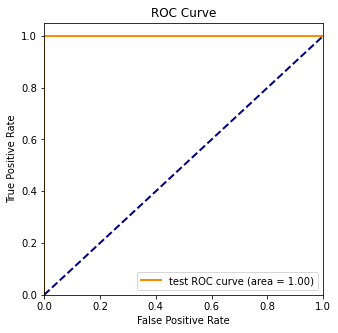


 最好情况下：epoch 462, 训练集正确率 0.989, 验证集正确率 1.000, Auc score 1.000, sensitivity 1.000, specificity 1.000 


<Figure size 432x288 with 0 Axes>

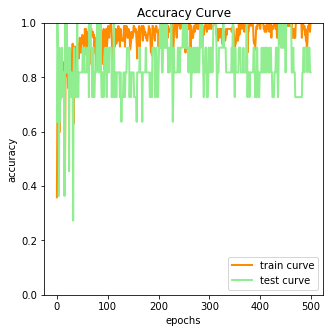

roc: 1.0
sensitivity: 1.0
specificity: 1.0
torch.Size([92, 2, 93])
torch.Size([11, 2, 93])
第1次10折交叉验证第2轮
 epoch 500, 训练集正确率 0.967, 验证集正确率 0.818, Auc score 0.857, sensitivity 1.000, specificity 0.714 

<Figure size 432x288 with 0 Axes>

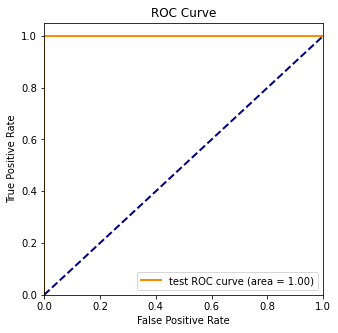


 最好情况下：epoch 484, 训练集正确率 0.967, 验证集正确率 1.000, Auc score 1.000, sensitivity 1.000, specificity 1.000 


<Figure size 432x288 with 0 Axes>

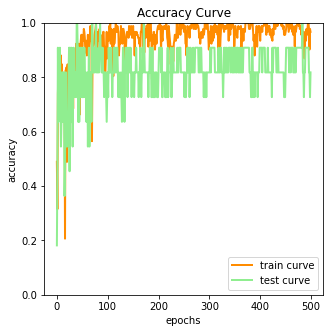

roc: 1.0
sensitivity: 1.0
specificity: 1.0
torch.Size([92, 2, 93])
torch.Size([11, 2, 93])
第1次10折交叉验证第3轮
 epoch 500, 训练集正确率 0.978, 验证集正确率 0.818, Auc score 0.817, sensitivity 0.833, specificity 0.800 

<Figure size 432x288 with 0 Axes>

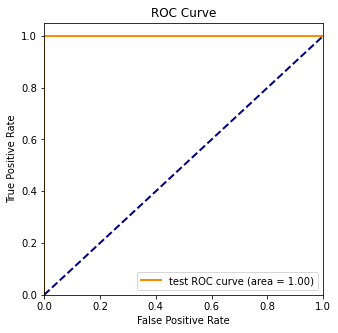


 最好情况下：epoch 411, 训练集正确率 0.935, 验证集正确率 1.000, Auc score 1.000, sensitivity 1.000, specificity 1.000 


<Figure size 432x288 with 0 Axes>

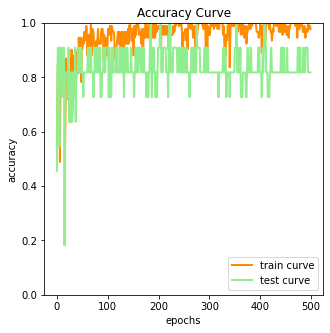

roc: 1.0
sensitivity: 1.0
specificity: 1.0
torch.Size([93, 2, 93])
torch.Size([10, 2, 93])
第1次10折交叉验证第4轮
 epoch 500, 训练集正确率 1.000, 验证集正确率 1.000, Auc score 1.000, sensitivity 1.000, specificity 1.000 

<Figure size 432x288 with 0 Axes>

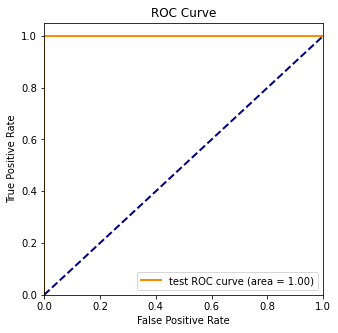


 最好情况下：epoch 500, 训练集正确率 1.000, 验证集正确率 1.000, Auc score 1.000, sensitivity 1.000, specificity 1.000 


<Figure size 432x288 with 0 Axes>

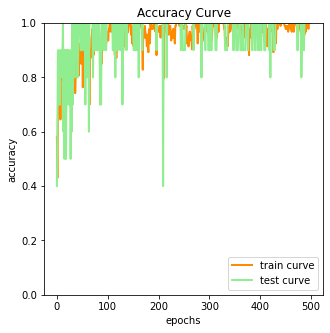

roc: 1.0
sensitivity: 1.0
specificity: 1.0
torch.Size([93, 2, 93])
torch.Size([10, 2, 93])
第1次10折交叉验证第5轮
 epoch 500, 训练集正确率 0.989, 验证集正确率 0.500, Auc score 0.500, sensitivity 0.400, specificity 0.600 

<Figure size 432x288 with 0 Axes>

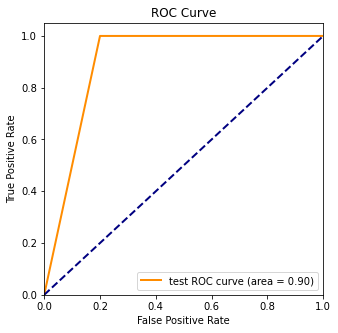


 最好情况下：epoch 312, 训练集正确率 0.978, 验证集正确率 0.900, Auc score 0.900, sensitivity 0.800, specificity 1.000 


<Figure size 432x288 with 0 Axes>

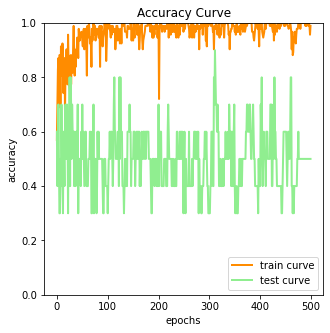

roc: 0.9
sensitivity: 0.8
specificity: 1.0
torch.Size([93, 2, 93])
torch.Size([10, 2, 93])
第1次10折交叉验证第6轮
 epoch 500, 训练集正确率 0.989, 验证集正确率 0.900, Auc score 0.917, sensitivity 0.833, specificity 1.000 

<Figure size 432x288 with 0 Axes>

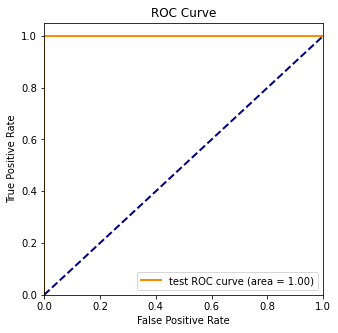


 最好情况下：epoch 454, 训练集正确率 1.000, 验证集正确率 1.000, Auc score 1.000, sensitivity 1.000, specificity 1.000 


<Figure size 432x288 with 0 Axes>

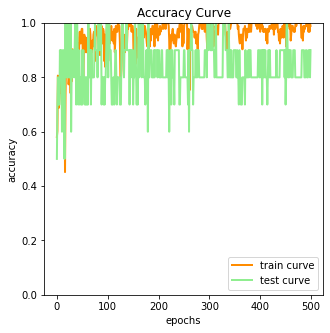

roc: 1.0
sensitivity: 1.0
specificity: 1.0
torch.Size([93, 2, 93])
torch.Size([10, 2, 93])
第1次10折交叉验证第7轮
 epoch 500, 训练集正确率 0.989, 验证集正确率 0.900, Auc score 0.900, sensitivity 0.800, specificity 1.000 

<Figure size 432x288 with 0 Axes>

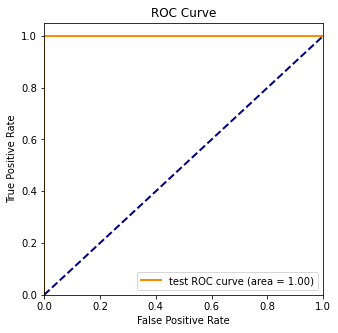


 最好情况下：epoch 495, 训练集正确率 0.978, 验证集正确率 1.000, Auc score 1.000, sensitivity 1.000, specificity 1.000 


<Figure size 432x288 with 0 Axes>

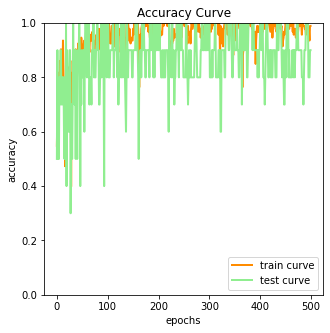

roc: 1.0
sensitivity: 1.0
specificity: 1.0
torch.Size([93, 2, 93])
torch.Size([10, 2, 93])
第1次10折交叉验证第8轮
 epoch 500, 训练集正确率 1.000, 验证集正确率 0.500, Auc score 0.722, sensitivity 1.000, specificity 0.444 

<Figure size 432x288 with 0 Axes>

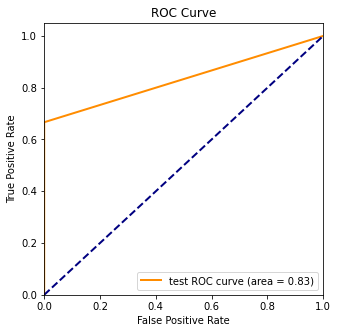


 最好情况下：epoch 320, 训练集正确率 1.000, 验证集正确率 0.700, Auc score 0.833, sensitivity 1.000, specificity 0.667 


<Figure size 432x288 with 0 Axes>

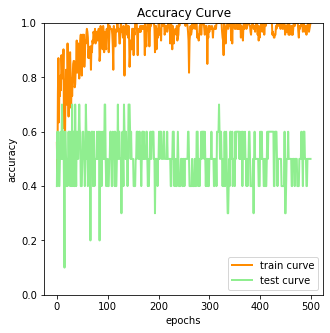

roc: 0.8333333333333333
sensitivity: 1.0
specificity: 0.6666666666666666
torch.Size([93, 2, 93])
torch.Size([10, 2, 93])
第1次10折交叉验证第9轮
 epoch 500, 训练集正确率 0.978, 验证集正确率 0.700, Auc score 0.786, sensitivity 0.571, specificity 1.000 

<Figure size 432x288 with 0 Axes>

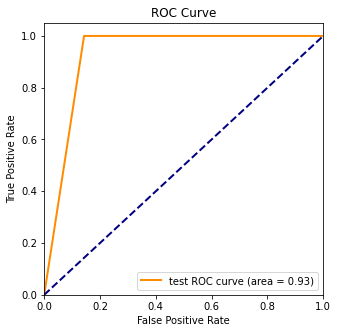


 最好情况下：epoch 446, 训练集正确率 0.978, 验证集正确率 0.900, Auc score 0.929, sensitivity 0.857, specificity 1.000 


<Figure size 432x288 with 0 Axes>

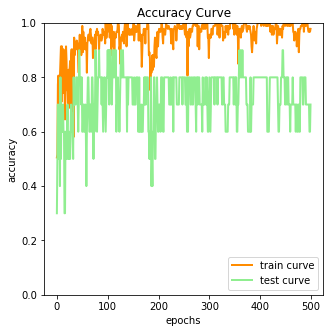

roc: 0.9285714285714286
sensitivity: 0.8571428571428571
specificity: 1.0
torch.Size([93, 2, 93])
torch.Size([10, 2, 93])
第1次10折交叉验证第10轮
 epoch 500, 训练集正确率 1.000, 验证集正确率 0.700, Auc score 0.786, sensitivity 0.571, specificity 1.000 

<Figure size 432x288 with 0 Axes>

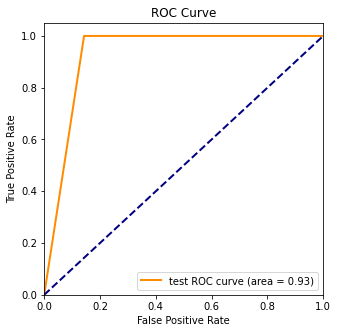


 最好情况下：epoch 385, 训练集正确率 0.978, 验证集正确率 0.900, Auc score 0.929, sensitivity 0.857, specificity 1.000 


<Figure size 432x288 with 0 Axes>

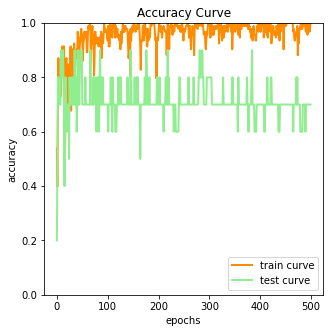

roc: 0.9285714285714286
sensitivity: 0.8571428571428571
specificity: 1.0
average test accuracy: 0.932
average train accuracy: 0.9805282842449744
average roc: 0.959047619047619
average sensitivity: 0.9514285714285714
average specificity: 0.9666666666666666


<Figure size 432x288 with 0 Axes>

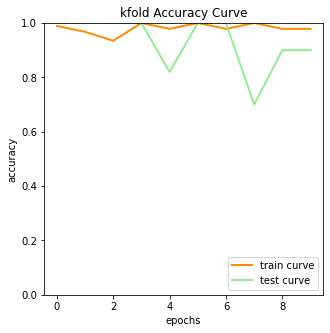

In [21]:
kfold_train_test(10)